# Preparing and testing functions

In [658]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np

class DataCleaner:
    def __init__(self, file_path):
        self.file_path = file_path

    def load_data(self):
        return pd.read_csv(self.file_path)

    def clean_data(self, df):
        # Drop columns with a large number of missing values
        df = df.drop(['weight', 'payer_code', 'medical_specialty'], axis=1)

        # Drop rows with specific missing values
        df = df[df['diag_1'] != '?']
        df = df[df['diag_2'] != '?']
        df = df[df['diag_3'] != '?']
        df = df[df['race'] != '?']
        df = df[df['gender'] != 'Unknown/Invalid']
        df = df[df['discharge_disposition_id'] != 11]

        # Replace values in A1Cresult and max_glu_serum
        a1c_replacements = {'>7': 1, '>8': 1, 'Norm': 0}
        df['A1Cresult'] = df['A1Cresult'].replace(a1c_replacements).fillna(-99)

        max_glu_serum_replacements = {'>200': 1, '>300': 1, 'Norm': 0}
        df['max_glu_serum'] = df['max_glu_serum'].replace(max_glu_serum_replacements).fillna(-99)

        # Drop columns with identical values in all rows
        columns_to_drop = ['examide', 'citoglipton', 'metformin-rosiglitazone']
        df = df.drop(columns_to_drop, axis=1)

        return df

    def feature_engineering(self, df):
        # Comorbidity count
        comorbidity_ranges = {
            'infectious_parasitic_diseases': (1, 139),
            'neoplasms': (140, 239),
            'endocrine_nutritional_metabolic_immunity_disorders': (240, 279),
            'blood_diseases': (280, 289),
            'mental_disorders': (290, 319),
            'nervous_system_diseases': (320, 389),
            'circulatory_system_diseases': (390, 459),
            'respiratory_system_diseases': (460, 519),
            'digestive_system_diseases': (520, 579),
            'genitourinary_system_diseases': (580, 629),
            'pregnancy_childbirth_complications': (630, 679),
            'skin_diseases': (680, 709),
            'musculoskeletal_system_diseases': (710, 739),
            'congenital_anomalies': (740, 759),
            'perinatal_conditions': (760, 779),
            'symptoms_signs_ill_defined_conditions': (780, 799),
            'injury_poisoning': (800, 999),
            'external_causes_supplemental': ('E', 'V')
        }

        def is_comorbidity(code, comorbidity_ranges):
            try:
                code_int = int(code)
                for comorbidity, (start, end) in comorbidity_ranges.items():
                    if start != 'E' and start != 'V' and start <= code_int <= end:
                        return True
            except ValueError:
                if any(code.startswith(prefix) for prefix in ['E', 'V']):
                    return True
            return False

        def count_comorbidities(row, comorbidity_ranges):
            count = 0
            if is_comorbidity(row['diag_1'], comorbidity_ranges):
                count += 1
            if is_comorbidity(row['diag_2'], comorbidity_ranges):
                count += 1
            if is_comorbidity(row['diag_3'], comorbidity_ranges):
                count += 1
            return count

        df['comorbidity_count'] = df.apply(lambda row: count_comorbidities(row, comorbidity_ranges), axis=1)

        # Visit history summary
        df['total_visits'] = df['number_outpatient'] + df['number_emergency'] + df['number_inpatient']

        # Recode columns
        admission_type_mapping = {2: 1, 7: 1, 6: 5, 8: 5}
        discharge_disposition_mapping = {
            6: 1, 8: 1, 9: 1, 13: 1, 3: 2, 4: 2, 5: 2, 14: 2, 22: 2, 23: 2, 24: 2, 12: 10,
            15: 10, 16: 10, 17: 10, 25: 18, 26: 18
        }
        admission_source_mapping = {
            2: 1, 3: 1, 5: 4, 6: 4, 10: 4, 22: 4, 25: 4, 15: 9, 17: 9, 20: 9, 21: 9, 13: 11, 14: 11
        }

        df['admission_type_id'] = df['admission_type_id'].replace(admission_type_mapping)
        df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(discharge_disposition_mapping)
        df['admission_source_id'] = df['admission_source_id'].replace(admission_source_mapping)

        # Long stay feature
        df['long_stay'] = (df['time_in_hospital'] > 7).astype(int)

        # Medication columns
        medication_cols = df.loc[:, 'metformin':'metformin-pioglitazone'].columns
        for col in medication_cols:
            colname = str(col) + 'temp'
            df[colname] = df[col].apply(lambda x: 0 if (x == 'No' or x == 'Steady') else 1)
        df['numchange'] = df[[str(col) + 'temp' for col in medication_cols]].sum(axis=1)
        df.drop(columns=[str(col) + 'temp' for col in medication_cols], inplace=True)

        for col in medication_cols:
            df[col] = df[col].replace('No', 0)
            df[col] = df[col].replace('Steady', 1)
            df[col] = df[col].replace('Up', 1)
            df[col] = df[col].replace('Down', 1)

        # Number of medications used
        df['nummed'] = 0
        for col in medication_cols:
            df['nummed'] = df['nummed'] + df[col]


        # Calculate age_midpoint from age column
        age_mapping = {
            '[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35, '[40-50)': 45,
            '[50-60)': 55, '[60-70)': 65, '[70-80)': 75, '[80-90)': 85, '[90-100)': 95
        }
        df['age'] = df['age'].replace(age_mapping)

        # Convert change to numeric
        df['change'] = df['change'].replace('Ch', 1)
        df['change'] = df['change'].replace('No', 0)

        # Interaction terms
        interaction_terms = [
            ('num_medications', 'time_in_hospital'),
            ('num_medications', 'num_procedures'),
            ('time_in_hospital', 'num_lab_procedures'),
            ('num_medications', 'num_lab_procedures'),
            ('num_medications', 'number_diagnoses'),
            ('age', 'number_diagnoses'),
            ('age', 'comorbidity_count'),
            ('change', 'num_medications'),
            ('number_diagnoses', 'time_in_hospital'),
            ('num_medications', 'numchange')
        ]

        for inter in interaction_terms:
            name = inter[0] + '|' + inter[1]
            df[name] = df[inter[0]] * df[inter[1]]

        # Categorizing diagnosis
        for col in ['diag_1', 'diag_2', 'diag_3']:
            df[f'level1_{col}'] = df[col]

        for col in ['level1_diag_1', 'level1_diag_2', 'level1_diag_3']:
            df[col] = df[col].replace({r'^V.*': 0, r'^E.*': 0}, regex=True)

        df.replace('?', -1, inplace=True)

        for col in ['level1_diag_1', 'level1_diag_2', 'level1_diag_3']:
            df[col] = df[col].astype(float)

        def classify_diag_level1(value):
            if value >= 390 and value < 460 or np.floor(value) == 785:
                return 1
            elif value >= 460 and value < 520 or np.floor(value) == 786:
                return 2
            elif value >= 520 and value < 580 or np.floor(value) == 787:
                return 3
            elif np.floor(value) == 250:
                return 4
            elif value >= 800 and value < 1000:
                return 5
            elif value >= 710 and value < 740:
                return 6
            elif value >= 580 and value < 630 or np.floor(value) == 788:
                return 7
            elif value >= 140 and value < 240:
                return 8
            else:
                return 0

        df['level1_diag_1'] = df['level1_diag_1'].apply(classify_diag_level1)
        df['level1_diag_2'] = df['level1_diag_2'].apply(classify_diag_level1)
        df['level1_diag_3'] = df['level1_diag_3'].apply(classify_diag_level1)

        # Drop original columns that have been encoded or aggregated
        df.drop(['number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3'],
          axis=1, inplace=True)

        # Change column data types
        cols = ['encounter_id', 'patient_nbr', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'A1Cresult', 'max_glu_serum']
        df[cols] = df[cols].astype('object')

        # Encoding the target variable
        readmitted_mapping = {'>30': 0, '<30': 1, 'NO': 0}
        df['readmitted'] = df['readmitted'].replace(readmitted_mapping)

        # Dropping Duplicates
        df = df.drop_duplicates(subset= ['patient_nbr'], keep = 'first')
        df = df.drop(['encounter_id', 'patient_nbr'], axis=1)

        return df


In [659]:
data_cleaner = DataCleaner('../raw_data/diabetic_data.csv')
data = data_cleaner.load_data()
cleaned_data = data_cleaner.clean_data(data)
processed_data = data_cleaner.feature_engineering(cleaned_data)


/var/folders/kh/9cscmqrj09n3l4w8g1mdk_sw0000gn/T/ipykernel_78620/2622891348.py:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['A1Cresult'] = df['A1Cresult'].replace(a1c_replacements).fillna(-99)
/var/folders/kh/9cscmqrj09n3l4w8g1mdk_sw0000gn/T/ipykernel_78620/2622891348.py:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['max_glu_serum'] = df['max_glu_serum'].replace(max_glu_serum_replacements).fillna(-99)
/var/folders/kh/9cscmqrj09n3l4w8g1mdk_sw0000gn/T/ipykernel_78620/2622891348.py:116: FutureWarning: Downcasting behav

In [660]:
data.shape

(101766, 50)

In [661]:
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: xlabel='number_emergency', ylabel='Count'>

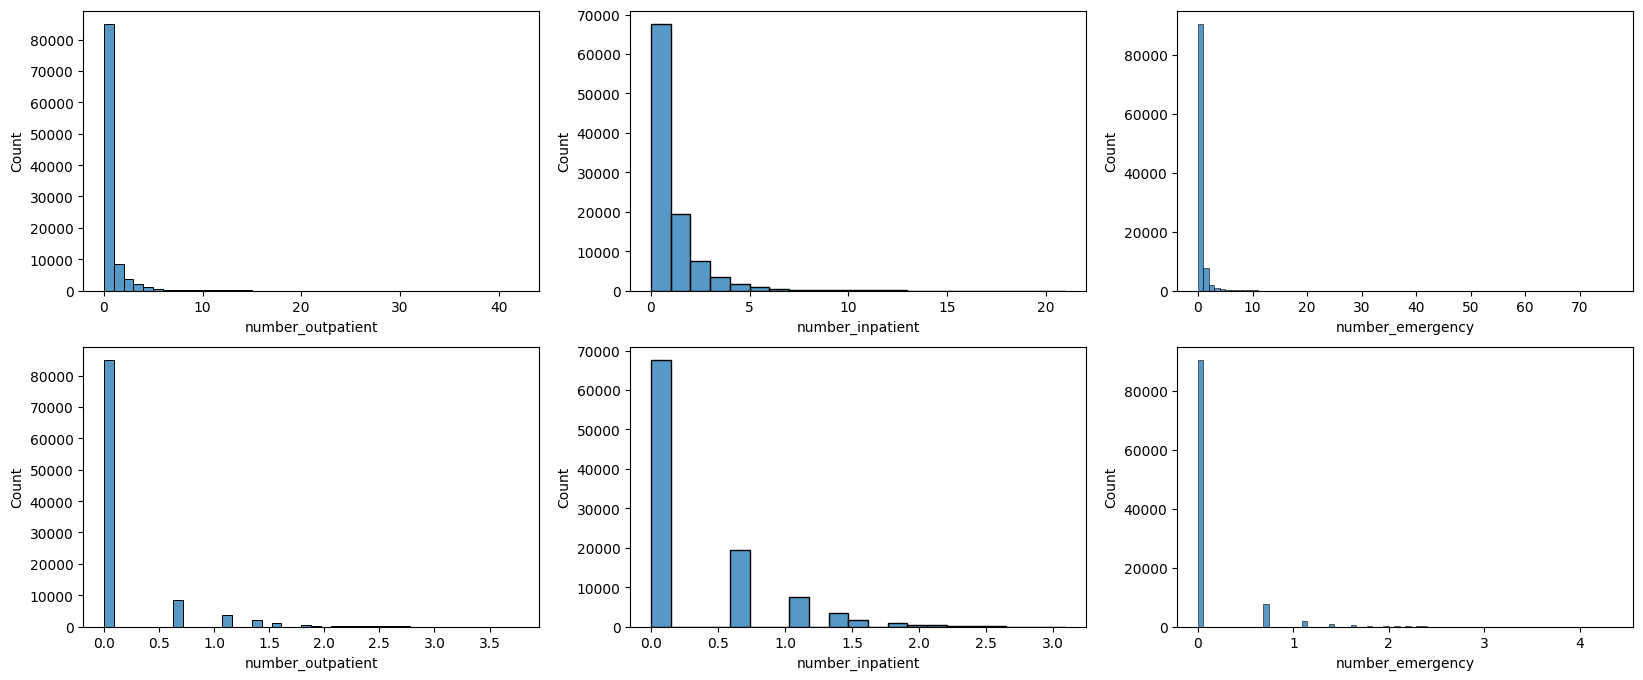

In [662]:
plt.figure(figsize=(20,8))

plt.subplot(2, 3, 1)
sns.histplot(data['number_outpatient'], bins=data['number_outpatient'].max())
plt.subplot(2, 3, 2)
sns.histplot(data['number_inpatient'], bins=data['number_inpatient'].max())
plt.subplot(2, 3, 3)
sns.histplot(data['number_emergency'], bins=data['number_emergency'].max())
plt.subplot(2, 3, 4)
sns.histplot(data['number_outpatient'].apply(lambda x: (np.log(x+1))), bins=data['number_outpatient'].max())
plt.subplot(2, 3, 5)
sns.histplot(data['number_inpatient'].apply(lambda x: (np.log(x+1))), bins=data['number_inpatient'].max())
plt.subplot(2, 3, 6)
sns.histplot(data['number_emergency'].apply(lambda x: (np.log(x+1))), bins=data['number_emergency'].max())

In [663]:
df = processed_data.copy()
df

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,comorbidity_count,total_visits,long_stay,numchange,nummed,num_medications|time_in_hospital,num_medications|num_procedures,time_in_hospital|num_lab_procedures,num_medications|num_lab_procedures,num_medications|number_diagnoses,age|number_diagnoses,age|comorbidity_count,change|num_medications,number_diagnoses|time_in_hospital,num_medications|numchange,level1_diag_1,level1_diag_2,level1_diag_3
1,Caucasian,Female,15,1,1,7,3,59,0,18,9,-99.0,-99.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,Yes,0,2,0,0,1,1,54,0,177,1062,162,135,30,18,27,18,0,4,0
2,AfricanAmerican,Female,25,1,1,7,2,11,5,13,6,-99.0,-99.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Yes,0,3,3,0,0,1,26,65,22,143,78,150,75,0,12,0,0,4,0
3,Caucasian,Male,35,1,1,7,2,44,1,16,7,-99.0,-99.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,Yes,0,2,0,0,1,1,32,16,88,704,112,245,70,16,14,16,0,4,1
4,Caucasian,Male,45,1,1,7,1,51,0,8,5,-99.0,-99.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,Yes,0,3,0,0,0,2,8,0,51,408,40,225,135,8,5,0,8,8,4
5,Caucasian,Male,55,1,1,1,3,31,6,16,9,-99.0,-99.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,Yes,0,3,0,0,0,1,48,96,93,496,144,495,165,0,27,0,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101754,Caucasian,Female,75,1,1,7,9,50,2,33,9,-99.0,1.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,Yes,0,2,0,1,1,2,297,66,450,1650,297,675,150,33,81,33,3,3,4
101755,Other,Female,45,1,1,7,14,73,6,26,9,-99.0,1.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,Yes,0,3,1,1,1,2,364,156,1022,1898,234,405,135,26,126,26,7,7,2
101756,Other,Female,65,1,1,7,2,46,6,17,9,-99.0,-99.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,Yes,0,3,3,0,0,1,34,102,92,782,153,585,195,0,18,0,5,7,1
101758,Caucasian,Female,85,1,1,7,5,76,1,22,9,-99.0,-99.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,Yes,0,3,1,0,1,1,110,22,380,1672,198,765,255,22,45,22,0,0,0


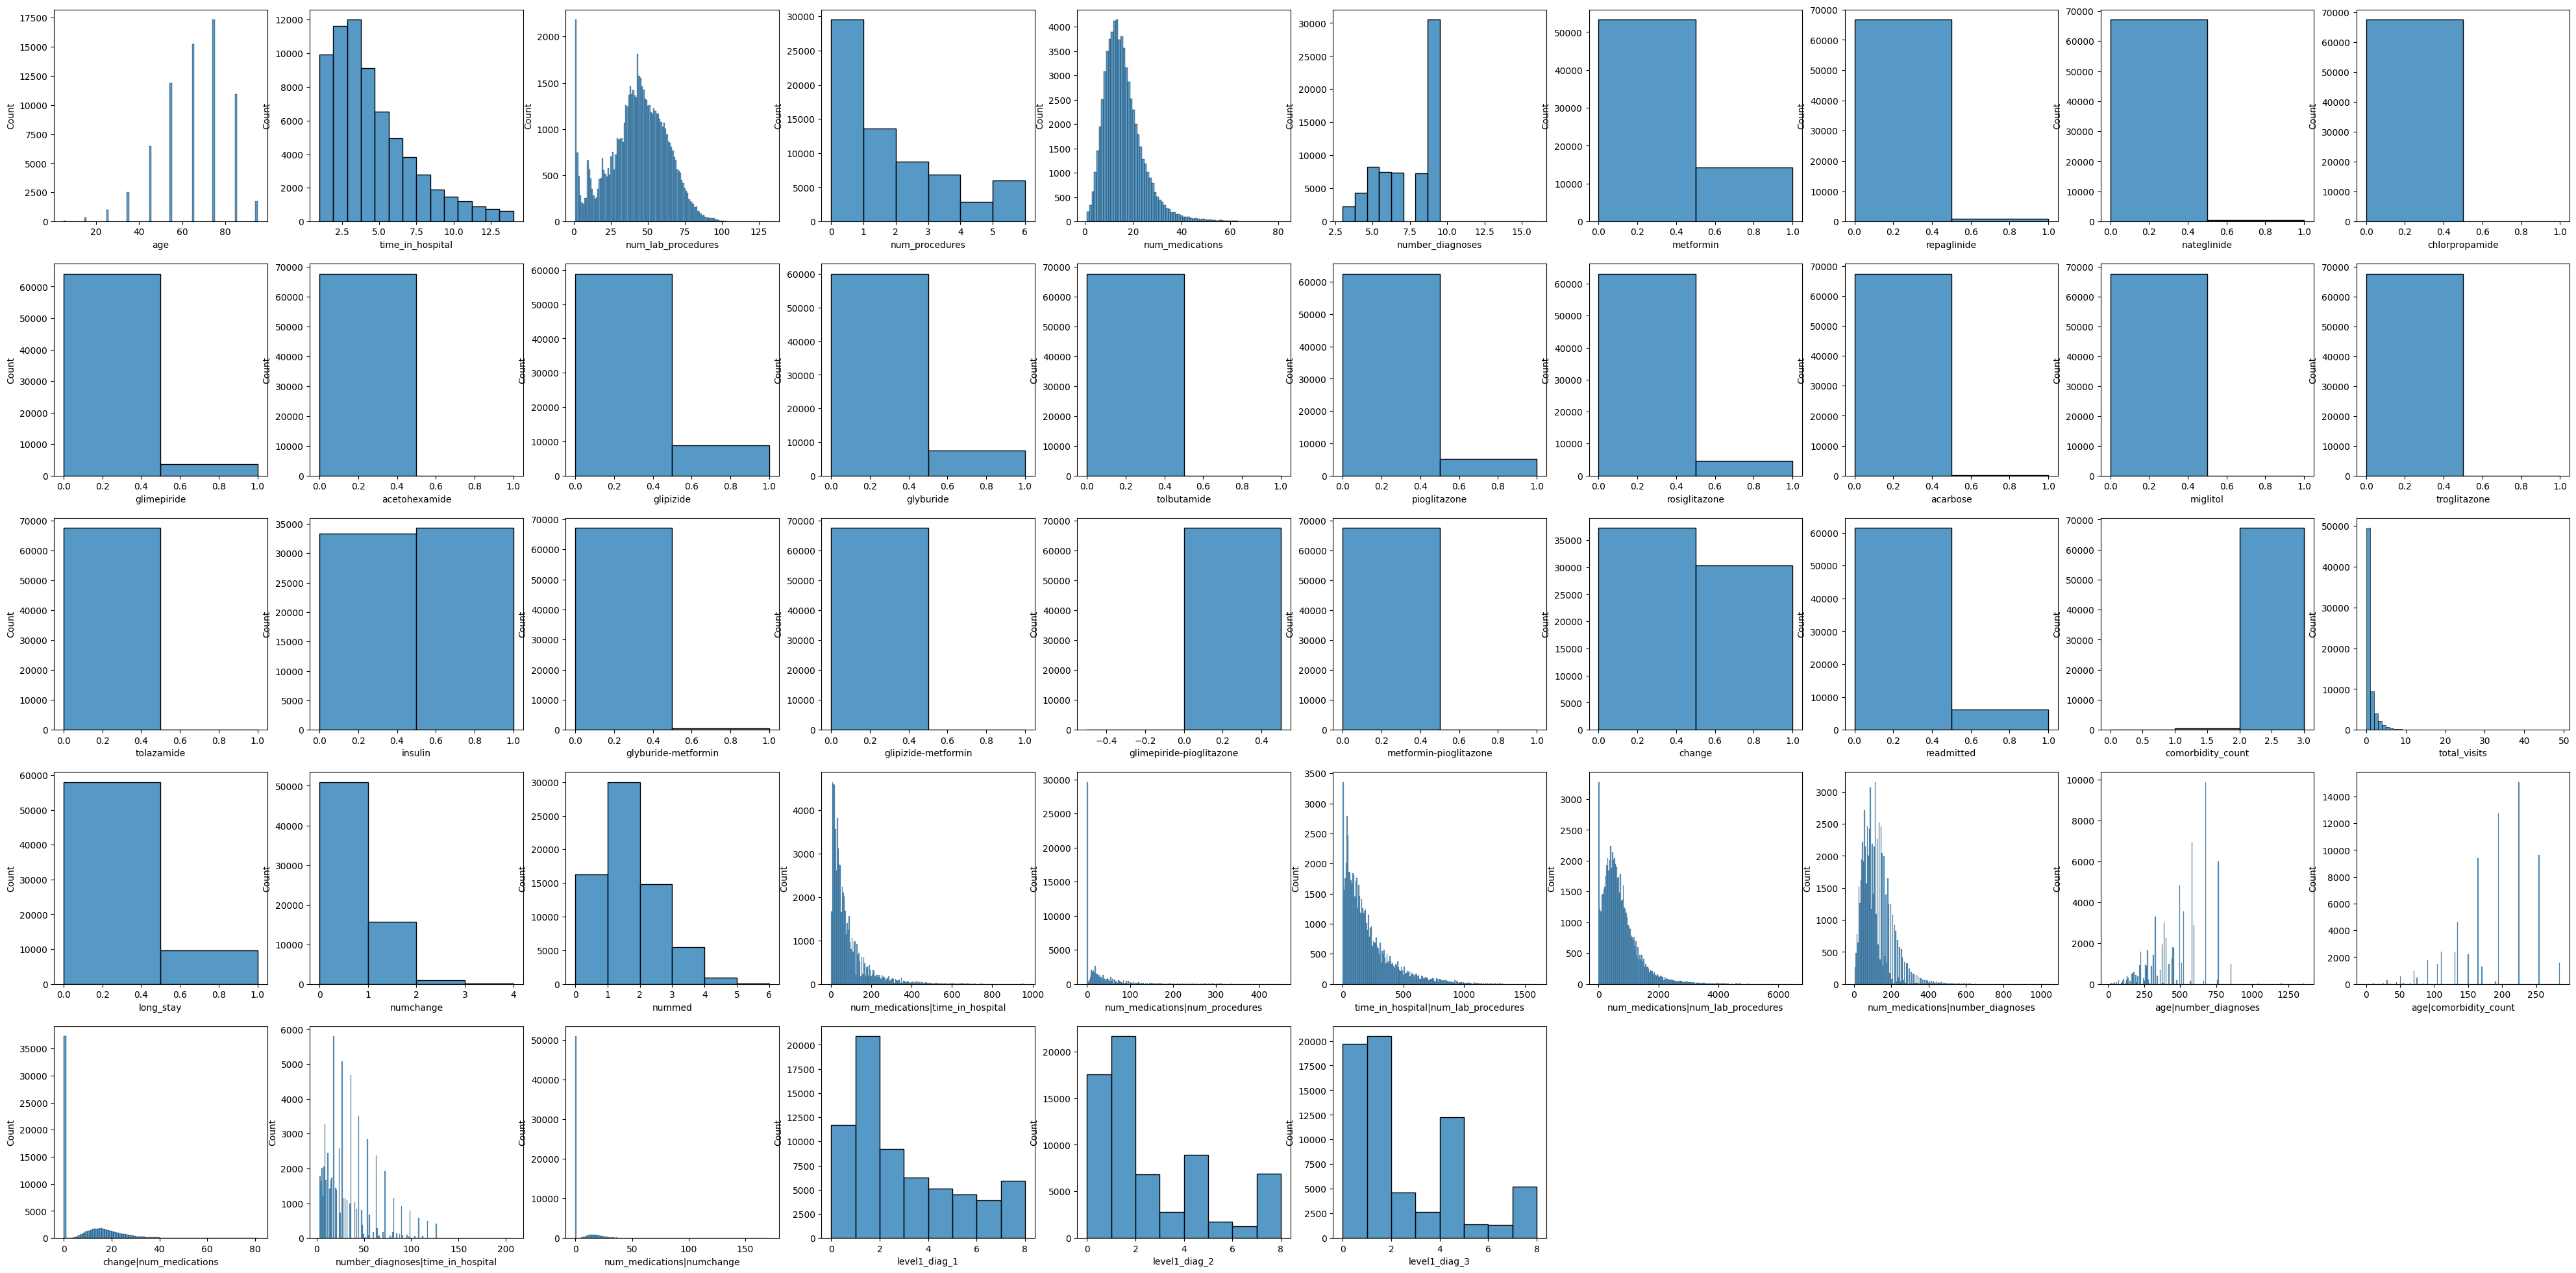

In [664]:
plt.figure(figsize=(50,50))

for i in range(processed_data.select_dtypes('number').shape[1]):
    plt.subplot(10, 10, i+1)
    bins = abs(processed_data.select_dtypes('number').iloc[:, i]).max()
    sns.histplot(processed_data.select_dtypes('number').iloc[:, i], bins=min(max(2, bins), 200))


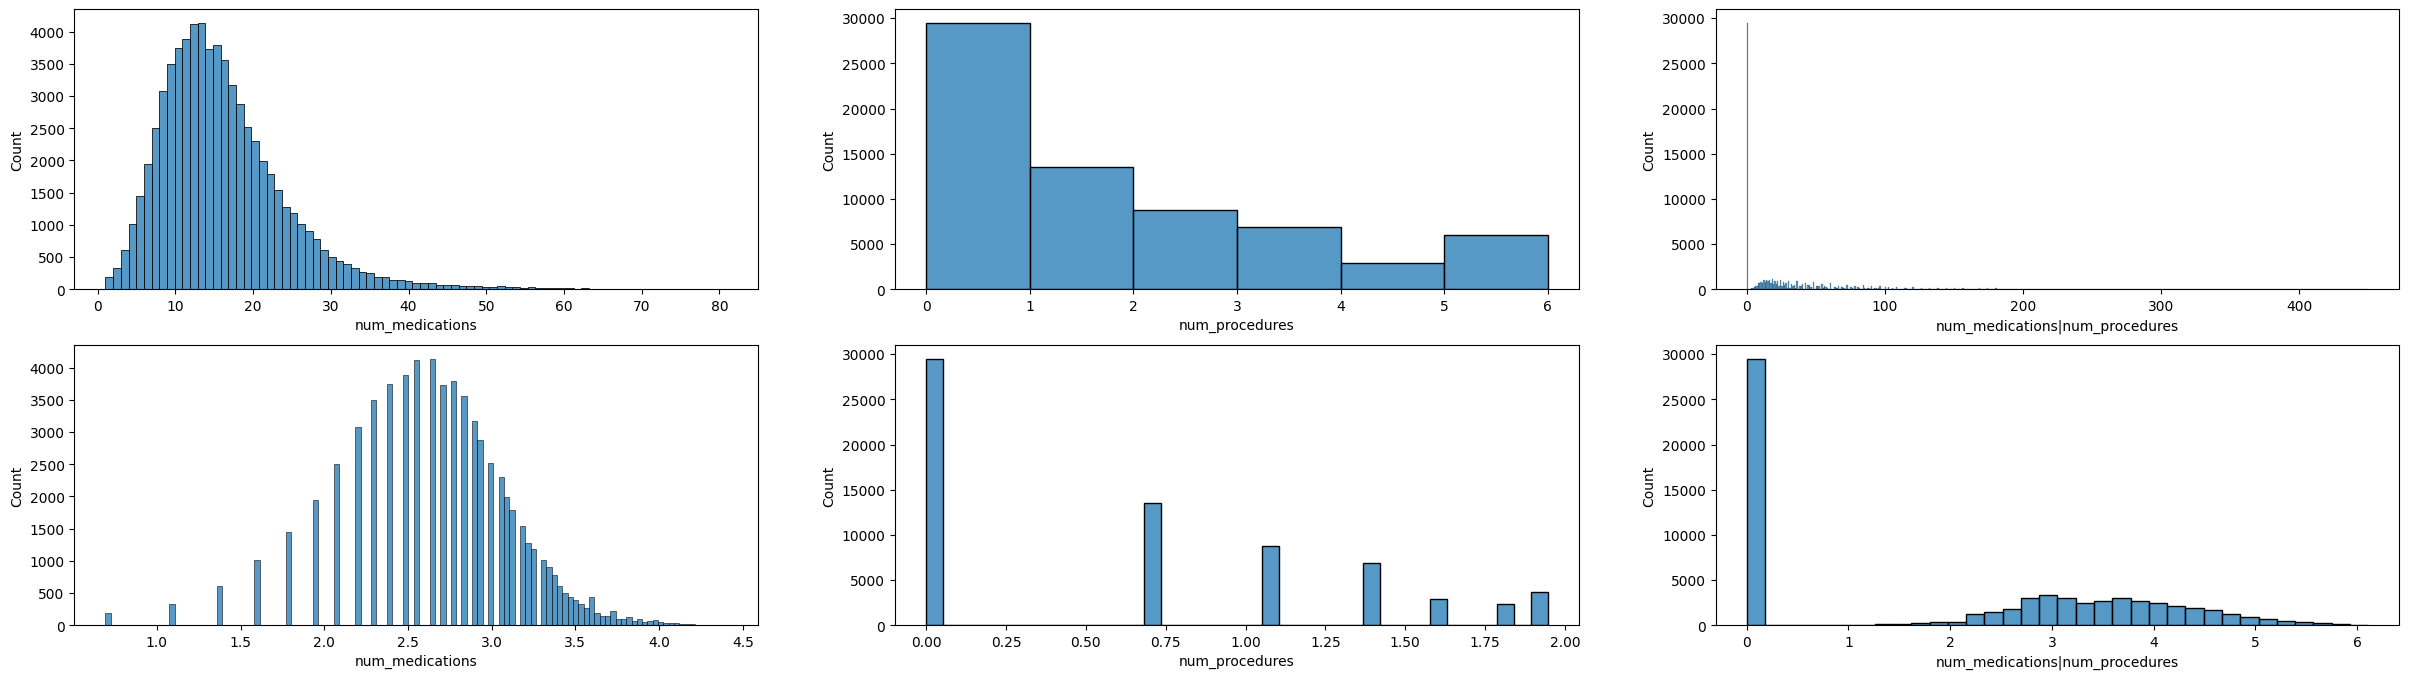

In [665]:
plt.figure(figsize=(30,8))
columns = ['num_medications',
           'num_procedures',
           'num_medications|num_procedures']


for plot, column in enumerate(columns):
    bins = processed_data[column].max()
    plt.subplot(2, 3, plot+1)
    sns.histplot(processed_data[column], bins=bins)
    plt.subplot(2, 3, plot+1+len(columns))
    sns.histplot(processed_data[column].apply(lambda x: (np.log(x+1))))


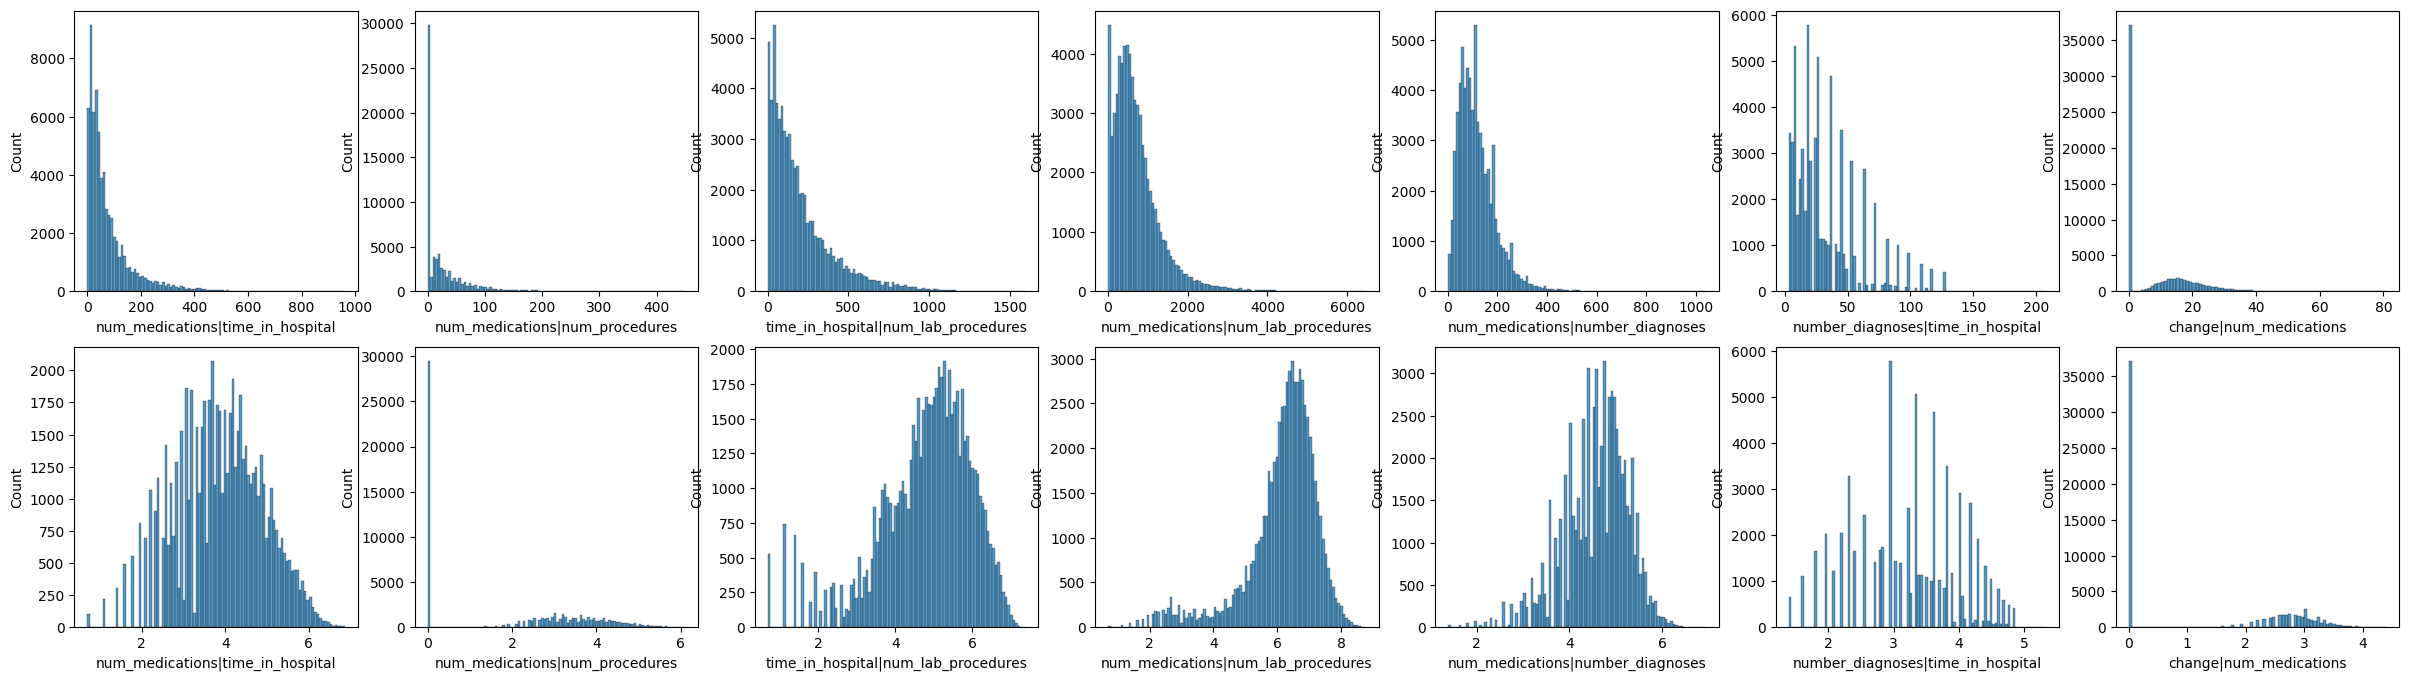

In [666]:
plt.figure(figsize=(30,8))
skewed_columns = ['num_medications|time_in_hospital',
                  'num_medications|num_procedures',
                  'time_in_hospital|num_lab_procedures',
                  'num_medications|num_lab_procedures',
                  'num_medications|number_diagnoses',
                  'number_diagnoses|time_in_hospital',
                  'change|num_medications']


for plot, column in enumerate(skewed_columns):
    bins = min(processed_data[column].max(), 100)
    plt.subplot(2, 7, plot+1)
    sns.histplot(processed_data[column], bins=bins)
    plt.subplot(2, 7, plot+1+len(skewed_columns))
    sns.histplot(processed_data[column].apply(lambda x: (np.log(x+1))), bins=bins)


# Applying log transform to selected features

In [667]:
skewed_columns = ['num_medications|time_in_hospital',
                  'num_medications|num_procedures',
                  'time_in_hospital|num_lab_procedures',
                  'num_medications|num_lab_procedures',
                  'num_medications|number_diagnoses',
                  'number_diagnoses|time_in_hospital',
                  'change|num_medications',
                  'total_visits',
                  ]

df = processed_data.copy()
# for column in skewed_columns:
#     df[column] = df[column].apply(lambda x: (np.log(x+1)))


# Holding out Validation Set

In [752]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df, test_size=0.2, random_state=0)

In [669]:
X_train = df_train.drop(columns=['readmitted']).copy()
y_train = df_train.readmitted.copy()

X_val = df_val.drop(columns=['readmitted']).copy()
y_val = df_val.readmitted.copy()

# Preprocessing Pipline

In [670]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.pipeline import Pipeline, FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_selector

In [671]:
num_preproc = Pipeline([
    ('scaler', MinMaxScaler()),
])

cat_preproc = Pipeline([
    ('ohe', OneHotEncoder(sparse_output=False, drop="if_binary")),
])

preproc = ColumnTransformer([
    ('num_transf', num_preproc, make_column_selector(dtype_include='number')),
    ('cat_transf', cat_preproc, make_column_selector(dtype_include='object')),
], verbose_feature_names_out=False).set_output(transform='pandas')

pipe_preproc = Pipeline([
    ('preprocessor', preproc),
])

pipe_preproc

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_transf',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x34703dde0>),
                                                 ('cat_transf',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x34703f940>)],
                                   verbose_feature_names_out=False))])

In [672]:
pipe_preproc.fit(X_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_transf',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x34703dde0>),
                                                 ('cat_transf',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x34703f940>)],
                                   verbose_feature_names_out=False))])

# Balancing via undersampling

In [673]:
bdf_bal = pd.concat([
    df_train[df_train.readmitted == 0].sample(len(df_train)//10),
    df_train[df_train.readmitted == 1]
])


In [674]:
X_bal = df_bal.drop(columns=['readmitted']).copy()
y_bal = df_bal.readmitted.copy()

In [676]:
X_bal_preproc = pipe_preproc.transform(X_bal)
X_bal_preproc

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-pioglitazone,change,comorbidity_count,total_visits,long_stay,numchange,nummed,num_medications|time_in_hospital,num_medications|num_procedures,time_in_hospital|num_lab_procedures,num_medications|num_lab_procedures,num_medications|number_diagnoses,age|number_diagnoses,age|comorbidity_count,change|num_medications,number_diagnoses|time_in_hospital,num_medications|numchange,level1_diag_1,level1_diag_2,level1_diag_3,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Male,admission_type_id_1,admission_type_id_3,admission_type_id_4,admission_type_id_5,discharge_disposition_id_1,discharge_disposition_id_2,discharge_disposition_id_7,discharge_disposition_id_10,discharge_disposition_id_18,discharge_disposition_id_19,discharge_disposition_id_20,discharge_disposition_id_27,discharge_disposition_id_28,admission_source_id_1,admission_source_id_4,admission_source_id_7,admission_source_id_8,admission_source_id_9,admission_source_id_11,max_glu_serum_-99.0,max_glu_serum_0.0,max_glu_serum_1.0,A1Cresult_-99.0,A1Cresult_0.0,A1Cresult_1.0,diabetesMed_Yes
60959,0.666667,0.461538,0.198473,0.000000,0.2000,0.461538,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.666667,0.000000,0.0,0.25,0.333333,0.122789,0.000000,0.124421,0.070821,0.144648,0.423792,0.456140,0.209877,0.292683,0.099415,0.500,0.000,0.000,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
28794,0.777778,0.384615,0.396947,0.833333,0.1500,0.153846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.000000,0.000000,0.0,0.00,0.333333,0.080125,0.144444,0.209795,0.106386,0.059788,0.267658,0.789474,0.160494,0.131707,0.000000,0.750,0.750,0.875,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
56651,0.777778,0.153846,0.251908,0.166667,0.2250,0.461538,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.000000,0.000000,0.0,0.00,0.333333,0.058273,0.042222,0.066843,0.099737,0.162006,0.490706,0.789474,0.234568,0.117073,0.000000,0.750,0.125,0.500,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
31813,0.666667,0.538462,0.419847,0.000000,0.2125,0.461538,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.000000,0.102041,1.0,0.25,0.666667,0.148803,0.000000,0.295831,0.155714,0.153327,0.423792,0.684211,0.222222,0.336585,0.105263,0.250,0.125,0.500,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
79258,0.333333,0.461538,0.511450,0.000000,0.1500,0.153846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.666667,0.000000,0.0,0.25,0.166667,0.093652,0.000000,0.314361,0.136539,0.059788,0.118959,0.245614,0.160494,0.156098,0.076023,0.500,0.375,0.000,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87890,0.777778,0.153846,0.083969,0.333333,0.2750,0.307692,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.000000,0.000000,0.0,0.00,0.333333,0.070760,0.10222

In [725]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

model = LogisticRegression(max_iter=1000)
model.fit(X_bal_preproc, y_bal)
# y_pred = model.predict(X_test)
scores = ['accuracy', 'recall', 'precision', 'f1', 'roc_auc']
cv_results = cross_validate(model, X_bal_preproc, y_bal, cv=5, scoring=scores, n_jobs=-1)
for score in scores:
    print(f"{score}: {cv_results['test_'+score].mean():.4f}")


accuracy: 0.5867
recall: 0.4398
precision: 0.5909
f1: 0.5038
roc_auc: 0.6141


In [726]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
X_val_preproc = pipe_preproc.transform(X_val)
model = LogisticRegression(max_iter=1000)
model.fit(X_bal_preproc, y_bal)


y_val_pred = model.predict(X_val_preproc)
print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")
print(f"Validation Recall: {recall_score(y_val, y_val_pred):.4f}")
print(f"Validation Precision: {precision_score(y_val, y_val_pred):.4f}")
print(f"Validation F1: {f1_score(y_val, y_val_pred):.4f}")
print(f"Validation ROC-AUC: {roc_auc_score(y_val, y_val_pred):.4f}")

Validation Accuracy: 0.7120
Validation Recall: 0.4708
Validation Precision: 0.1457
Validation F1: 0.2225
Validation ROC-AUC: 0.6030


In [745]:
from sklearn.inspection import permutation_importance

model = LogisticRegression(max_iter=1000)
model.fit(X_bal_preproc, y_bal)

# Perform the permutation
permutation_score = permutation_importance(model, X_bal_preproc, y_bal, scoring='roc_auc', n_repeats=10, n_jobs=-1)

# Unstack results showing the decrease in performance after shuffling features
importance_df = pd.DataFrame(np.vstack((X_bal_preproc.columns,
                                        permutation_score.importances_mean)).T)
importance_df.columns=['feature','score decrease']


In [746]:
# Show the important features
importance_df.sort_values(by="score decrease", ascending = False).head(20)

,feature,score decrease
55,discharge_disposition_id_1,0.081008
28,total_visits,0.018837
5,number_diagnoses,0.01786
27,comorbidity_count,0.015516
37,age|number_diagnoses,0.01102
38,age|comorbidity_count,0.010009
1,time_in_hospital,0.009826
59,discharge_disposition_id_18,0.008466
0,age,0.004773
33,num_medications|num_procedures,0.003991


 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76

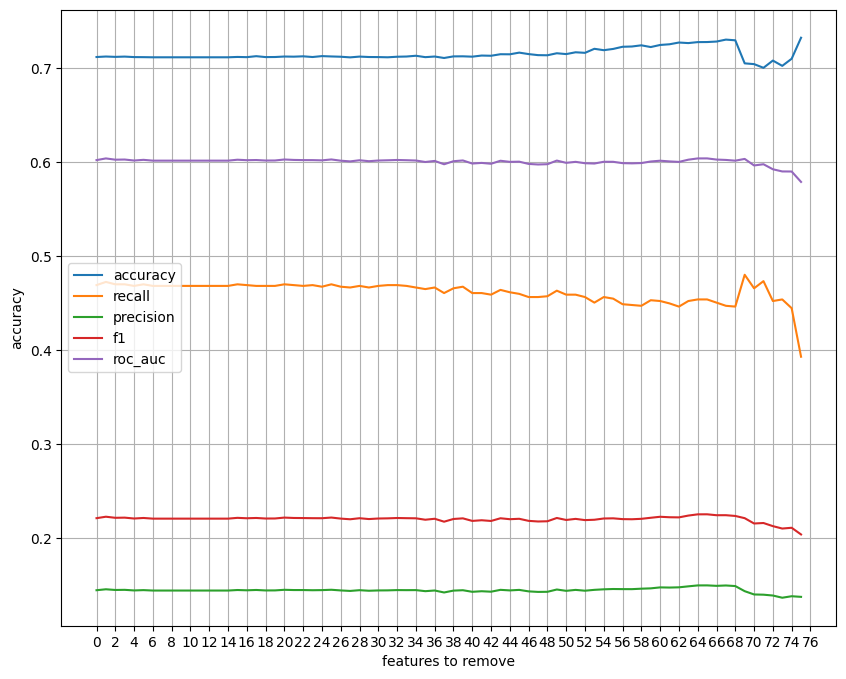

In [753]:
metrics = ['accuracy', 'recall', 'precision', 'f1', 'roc_auc']
scores = {metric: [] for metric in metrics}
n_features = X_bal_preproc.shape[1]

for cols_to_drop in range(1, n_features):
    print(f' {cols_to_drop}', end='')

    keep_col = importance_df.sort_values(by="score decrease", ascending = False).feature[:-cols_to_drop].to_list()
    X_bal_reduced = X_bal_preproc[keep_col]
    X_val_reduced = X_val_preproc[keep_col]

    model = LogisticRegression(max_iter=1000)
    model.fit(X_bal_reduced, y_bal)

    y_val_pred = model.predict(X_val_reduced)

    scores['accuracy'] = scores['accuracy'] + [accuracy_score(y_val, y_val_pred)]
    scores['recall'] = scores['recall'] + [recall_score(y_val, y_val_pred)]
    scores['precision'] = scores['precision'] + [precision_score(y_val, y_val_pred)]
    scores['f1'] = scores['f1'] + [f1_score(y_val, y_val_pred)]
    scores['roc_auc'] = scores['roc_auc'] + [roc_auc_score(y_val, y_val_pred)]

scores_df = pd.DataFrame(scores)

plt.figure(figsize=(10, 8))
for metric in metrics:
    sns.lineplot(scores_df[metric], label=metric)
plt.xlabel('features to remove')
plt.xticks([*range(0, n_features, 2)])
plt.grid(visible=True, which='both')
plt.legend(loc='center left')

In [750]:
n_features_to_remove = 69
keep_col = importance_df.sort_values(by="score decrease", ascending = False).feature[:-n_features_to_remove].to_list()
X_bal_reduced = X_bal_preproc[keep_col]
X_val_reduced = X_val_preproc[keep_col]

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
X_val_preproc = pipe_preproc.transform(X_val)

model = LogisticRegression(max_iter=1000)
model.fit(X_bal_reduced, y_bal)


y_val_pred = model.predict(X_val_reduced)
print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")
print(f"Validation Recall: {recall_score(y_val, y_val_pred):.4f}")
print(f"Validation Precision: {precision_score(y_val, y_val_pred):.4f}")
print(f"Validation F1: {f1_score(y_val, y_val_pred):.4f}")
print(f"Validation ROC-AUC: {roc_auc_score(y_val, y_val_pred):.4f}")
print(keep_col)

Validation Accuracy: 0.7292
Validation Recall: 0.4463
Validation Precision: 0.1494
Validation F1: 0.2239
Validation ROC-AUC: 0.6013
['discharge_disposition_id_1', 'total_visits', 'number_diagnoses', 'comorbidity_count', 'age|number_diagnoses', 'age|comorbidity_count', 'time_in_hospital', 'discharge_disposition_id_18']


# ------------------------------------------------------------------------------

In [6]:
import pickle
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
#from data import DataCleaner

# Load the data and preprocess
data_cleaner = DataCleaner('../raw_data/diabetic_data.csv')
data = data_cleaner.load_data()
cleaned_data = data_cleaner.clean_data(data)
processed_data = data_cleaner.feature_engineering(cleaned_data)

# Numeric preprocessing pipeline (excluding 'readmitted')
numeric_columns = [col for col in processed_data.select_dtypes(include=['number']).columns if col != 'readmitted']
num_preproc = Pipeline([
    ('scaler', StandardScaler())
])


# Categorical preprocessing pipeline (excluding 'age')
categorical_columns = processed_data.select_dtypes(include=['object']).columns
cat_preproc = Pipeline([
    ('ohe', OneHotEncoder(sparse_output=False, drop="if_binary", handle_unknown='ignore'))
])

# Combined preprocessing pipeline
preproc = ColumnTransformer([
    ('num_transf', num_preproc, numeric_columns),
    ('cat_transf', cat_preproc, categorical_columns)
], verbose_feature_names_out=False)


# Create a pipeline with SMOTE and preprocessing
pipe_preproc = ImbPipeline([
    ('preprocessor', preproc),
])
pipe_preproc


ModuleNotFoundError: No module named 'imblearn'

In [3]:
# Load the data and preprocess
data_cleaner = DataCleaner('../raw_data/diabetic_data.csv')
data = data_cleaner.load_data()
cleaned_data = data_cleaner.clean_data(data)
processed_data = data_cleaner.feature_engineering(cleaned_data)

X_train = processed_data.drop(columns=['readmitted'])
y_train = processed_data[['readmitted']]

X_train.shape, y_train.shape

/var/folders/nw/jh8cgbmd7zvcd0mxm5ks23pc0000gn/T/ipykernel_81212/3045994153.py:25: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['A1Cresult'] = df['A1Cresult'].replace(a1c_replacements).fillna(-99)
/var/folders/nw/jh8cgbmd7zvcd0mxm5ks23pc0000gn/T/ipykernel_81212/3045994153.py:28: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['max_glu_serum'] = df['max_glu_serum'].replace(max_glu_serum_replacements).fillna(-99)
/var/folders/nw/jh8cgbmd7zvcd0mxm5ks23pc0000gn/T/ipykernel_81212/3045994153.py:114: FutureWarning: Downcasting behav

((67580, 53), (67580, 1))

## Model

In [4]:
# Load the data and preprocess
data_cleaner = DataCleaner('../raw_data/diabetic_data.csv')
data = data_cleaner.load_data()
cleaned_data = data_cleaner.clean_data(data)
processed_data = data_cleaner.feature_engineering(cleaned_data)

# Apply the preprocessing pipeline to data
# Separate features and target
X = processed_data.drop('readmitted', axis=1)
y = processed_data['readmitted']

/var/folders/nw/jh8cgbmd7zvcd0mxm5ks23pc0000gn/T/ipykernel_81212/3045994153.py:25: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['A1Cresult'] = df['A1Cresult'].replace(a1c_replacements).fillna(-99)
/var/folders/nw/jh8cgbmd7zvcd0mxm5ks23pc0000gn/T/ipykernel_81212/3045994153.py:28: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['max_glu_serum'] = df['max_glu_serum'].replace(max_glu_serum_replacements).fillna(-99)
/var/folders/nw/jh8cgbmd7zvcd0mxm5ks23pc0000gn/T/ipykernel_81212/3045994153.py:114: FutureWarning: Downcasting behav

In [5]:
from sklearn.model_selection import train_test_split
# Split the data into training + validation and testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Further split the training + validation set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, shuffle=True)  # 0.25 * 0.8 = 0.2

In [6]:
# Fit and transform the training data with preprocessing pipeline
X_train_preprocessed = pipe_preproc.fit_transform(X_train)
X_val_preprocessed = pipe_preproc.transform(X_val)
X_test_preprocessed = pipe_preproc.transform(X_test)

In [7]:
# Save the preprocessing pipeline as a pickle file
with open('../preprocessor/preprocessing_pipeline.pkl', 'wb') as file:
    pickle.dump(pipe_preproc, file)

In [8]:
# Apply SMOTE to the preprocessed training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_preprocessed, y_train)

In [9]:
from collections import Counter

print(f"Original training set distribution: {Counter(y_train)}")
print(f"Resampled training set distribution: {Counter(y_train_smote)}")


Original training set distribution: Counter({0: 36877, 1: 3671})
Resampled training set distribution: Counter({0: 36877, 1: 36877})


In [10]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train_smote, y_train_smote)

GradientBoostingClassifier(random_state=42)

In [11]:
from sklearn.ensemble import RandomForestClassifier
rm = RandomForestClassifier(n_estimators=10, max_depth=25, criterion="gini", min_samples_split=10, class_weight={0: 1, 1: 10})

rm.fit(X_train_smote, y_train_smote)
best_model = rm

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
y_val_pred_gb = rm.predict(X_val_preprocessed)
print("Random Forest Validation Performance")
print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred_gb):.4f}")
print(f"Validation Precision: {precision_score(y_val, y_val_pred_gb):.4f}")
print(f"Validation Recall: {recall_score(y_val, y_val_pred_gb):.4f}")
gb_score = accuracy_score(y_val, y_val_pred_gb)

Random Forest Validation Performance
Validation Accuracy: 0.8151
Validation Precision: 0.1282
Validation Recall: 0.1832


In [13]:
y_test_pred = best_model.predict(X_test_preprocessed)
print("Best Model Test Performance")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Test Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Test Recall: {recall_score(y_test, y_test_pred):.4f}")

Best Model Test Performance
Test Accuracy: 0.8148
Test Precision: 0.1283
Test Recall: 0.1742


In [14]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[10796  1474]
 [ 1029   217]]


In [15]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('preprocessor', pipe_preproc),  # Use pipe_preproc without parentheses
    ('Random Forest', best_model)
])

# Check the pipeline
pipe


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(transformers=[('num_transf',
                                                                   Pipeline(steps=[('scaler',
                                                                                    StandardScaler())]),
                                                                   ['age',
                                                                    'time_in_hospital',
                                                                    'num_lab_procedures',
                                                                    'num_procedures',
                                                                    'num_medications',
                                                                    'number_diagnoses',
                                                                    'metformin',
                                                                    'repaglinide',
                                                                    'nateglinide',
                                                                    'chlorpropamide',
                                                                    'glimepiride',
                                                                    'acetohexamide',
                                                                    'glipi...
                                                                                                  handle_unknown='ignore',
                                                                                                  sparse_output=False))]),
                                                                   Index(['race', 'gender', 'admission_type_id', 'discharge_disposition_id',
       'admission_source_id', 'max_glu_serum', 'A1Cresult', 'diabetesMed'],
      dtype='object'))],
                                                    verbose_feature_names_out=False))])),
                ('Random Forest',
                 RandomForestClassifier(class_weight={0: 1, 1: 10},
                                        max_depth=25, min_samples_split=10,
                                        n_estimators=10))])

In [16]:
import pickle
with open('../models/best_model.pkl', 'wb') as file:
    pickle.dump(pipe, file)

In [17]:
# Assuming X_train is a Pandas DataFrame and X_train_preprocessed is a NumPy array after preprocessing
# Store the column names before preprocessing
original_columns = X_train.columns

# Fit and transform the training data with preprocessing pipeline
X_train_preprocessed = pipe_preproc.fit_transform(X_train)

# Assuming gb is already trained and X_train_preprocessed contains your training data after preprocessing
feature_importances = gb.feature_importances_

# Pair feature importances with original column names
feature_importance_dict = dict(zip(original_columns, feature_importances))

# Sort features by importance (descending order)
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Select top n features (e.g., top 10 features)
top_features = [feat for feat, importance in sorted_features[:10]]  # Adjust the number as per your requirement

print("Top 15 features:")
print(top_features)


Top 15 features:
['level1_diag_1', 'num_medications|number_diagnoses', 'insulin', 'race', 'change|num_medications', 'num_medications|num_lab_procedures', 'time_in_hospital|num_lab_procedures', 'level1_diag_2', 'gender', 'admission_type_id']


In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier

# Define a function to test various feature combinations
def find_combinations_for_yes(model, preprocessor):
    # Define possible values for key features
    feature_values = {
        'age': [25, 45, 65, 75],
        'gender': ['Male', 'Female'],
        'race': ['AfricanAmerican', 'Caucasian'],
        'level1_diag_1': [1, 0, 8],
        'insulin': [0, 1],
        'change': [0, 1],
        'num_lab_procedures': [40, 50, 60],
        'num_medications': [11, 12, 15],
        'number_diagnoses': [5],
        'admission_type_id': ['1'],
        'time_in_hospital': [2, 7, 14]
    }

    # Fixed values for other features
    fixed_values = {
        'discharge_disposition_id': "1",
        'admission_source_id': "7",
        'num_procedures': 1,
        'max_glu_serum': "-99.0",
        'A1Cresult': "-99.0",
        'metformin': 0,
        'repaglinide': 0,
        'nateglinide': 0,
        'chlorpropamide': 0,
        'glimepiride': 0,
        'acetohexamide': 0,
        'glipizide': 0,
        'glyburide': 0,
        'tolbutamide': 0,
        'pioglitazone': 0,
        'rosiglitazone': 0,
        'acarbose': 0,
        'miglitol': 0,
        'troglitazone': 0,
        'tolazamide': 0,
        'insulin': 1,
        'glyburide-metformin': 0,
        'glipizide-metformin': 0,
        'glimepiride-pioglitazone': 0,
        'metformin-pioglitazone': 0,
        'diabetesMed': 'Yes',
        'comorbidity_count': 3,
        'total_visits': 0,
        'long_stay': 0,
        'numchange': 1,
        'nummed': 1,
        'num_medications|time_in_hospital': 54,
        'num_medications|num_procedures': 0,
        'time_in_hospital|num_lab_procedures': 177,
        'num_medications|num_lab_procedures': 1062,
        'num_medications|number_diagnoses': 162,
        'age|number_diagnoses': 135,
        'age|comorbidity_count': 30,
        'change|num_medications': 18,
        'number_diagnoses|time_in_hospital': 27,
        'num_medications|numchange': 18,
        'level1_diag_2': 1,
        'level1_diag_3': 1
    }

    results = []

    # Generate all combinations of key feature values
    for age in feature_values['age']:
        for gender in feature_values['gender']:
            for race in feature_values['race']:
                for level1_diag_1 in feature_values['level1_diag_1']:
                    for insulin in feature_values['insulin']:
                        for change in feature_values['change']:
                            for num_lab_procedures in feature_values['num_lab_procedures']:
                                for num_medications in feature_values['num_medications']:
                                    for number_diagnoses in feature_values['number_diagnoses']:
                                        for admission_type_id in feature_values['admission_type_id']:
                                            for time_in_hospital in feature_values['time_in_hospital']:
                                                # Create a DataFrame with the current combination and fixed values
                                                test_df = pd.DataFrame({
                                                    'age': [age],
                                                    'gender': [gender],
                                                    'race': [race],
                                                    'level1_diag_1': [level1_diag_1],
                                                    'insulin': [insulin],
                                                    'change': [change],
                                                    'num_lab_procedures': [num_lab_procedures],
                                                    'num_medications': [num_medications],
                                                    'number_diagnoses': [number_diagnoses],
                                                    'admission_type_id': [admission_type_id],
                                                    'time_in_hospital': [time_in_hospital],
                                                    # Include fixed values for the other features
                                                    **{k: [v] for k, v in fixed_values.items()}
                                                })

                                                # Preprocess the data
                                                preprocessed_data = preprocessor.transform(test_df)

                                                # Make prediction
                                                prediction = model.predict(preprocessed_data)[0]

                                                if prediction == 1:
                                                    results.append({
                                                        'age': age,
                                                        'gender': gender,
                                                        'race': race,
                                                        'level1_diag_1': level1_diag_1,
                                                        'insulin': insulin,
                                                        'change': change,
                                                        'num_lab_procedures': num_lab_procedures,
                                                        'num_medications': num_medications,
                                                        'number_diagnoses': number_diagnoses,
                                                        'admission_type_id': admission_type_id,
                                                        'time_in_hospital': time_in_hospital
                                                    })

    return results

# Example usage
# Load your model and preprocessor
# Assuming 'best_model' is your trained model and 'pipe_preproc' is your preprocessing pipeline
combinations_for_yes = find_combinations_for_yes(best_model, pipe_preproc)

print("Combinations that lead to a 'YES' prediction:")
for combo in combinations_for_yes:
    print(combo)

/Users/virginiawenger/.pyenv/versions/3.10.6/envs/hospital_readmission/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2, 3, 4, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/virginiawenger/.pyenv/versions/3.10.6/envs/hospital_readmission/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2, 3, 4, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/virginiawenger/.pyenv/versions/3.10.6/envs/hospital_readmission/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2, 3, 4, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/virginiawenger/.pyenv/versions/3.10.6/envs/hospital_readmission/lib/python3.10/site-packages/sklearn/preprocess

Combinations that lead to a 'YES' prediction:
{'age': 25, 'gender': 'Male', 'race': 'Caucasian', 'level1_diag_1': 1, 'insulin': 0, 'change': 0, 'num_lab_procedures': 50, 'num_medications': 11, 'number_diagnoses': 5, 'admission_type_id': '1', 'time_in_hospital': 7}
{'age': 25, 'gender': 'Male', 'race': 'Caucasian', 'level1_diag_1': 1, 'insulin': 0, 'change': 0, 'num_lab_procedures': 50, 'num_medications': 11, 'number_diagnoses': 5, 'admission_type_id': '1', 'time_in_hospital': 14}
{'age': 25, 'gender': 'Male', 'race': 'Caucasian', 'level1_diag_1': 1, 'insulin': 0, 'change': 0, 'num_lab_procedures': 50, 'num_medications': 12, 'number_diagnoses': 5, 'admission_type_id': '1', 'time_in_hospital': 7}
{'age': 25, 'gender': 'Male', 'race': 'Caucasian', 'level1_diag_1': 1, 'insulin': 0, 'change': 0, 'num_lab_procedures': 50, 'num_medications': 12, 'number_diagnoses': 5, 'admission_type_id': '1', 'time_in_hospital': 14}
{'age': 25, 'gender': 'Male', 'race': 'Caucasian', 'level1_diag_1': 1, 'insu

/Users/virginiawenger/.pyenv/versions/3.10.6/envs/hospital_readmission/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2, 3, 4, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/virginiawenger/.pyenv/versions/3.10.6/envs/hospital_readmission/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2, 3, 4, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/virginiawenger/.pyenv/versions/3.10.6/envs/hospital_readmission/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2, 3, 4, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/virginiawenger/.pyenv/versions/3.10.6/envs/hospital_readmission/lib/python3.10/site-packages/sklearn/preprocess

In [19]:
combinations_for_yes[1]

{'age': 25,
 'gender': 'Male',
 'race': 'Caucasian',
 'level1_diag_1': 1,
 'insulin': 0,
 'change': 0,
 'num_lab_procedures': 50,
 'num_medications': 11,
 'number_diagnoses': 5,
 'admission_type_id': '1',
 'time_in_hospital': 14}

In [24]:
input_data = {
    'age': 25,
    'gender': 'Male',
    'race': 'Caucasian',
    'level1_diag_1': 1,
    'insulin': 0,
    'change': 0,
    'num_lab_procedures': 50,
    'num_medications': 11,
    'number_diagnoses': 5,
    'admission_type_id': '1',
    'time_in_hospital': 14,
    'discharge_disposition_id': "1",
    'admission_source_id': "7",
    'num_procedures': 1,
    'max_glu_serum': "-99.0",
    'A1Cresult': "-99.0",
    'metformin': 0,
    'repaglinide': 0,
    'nateglinide': 0,
    'chlorpropamide': 0,
    'glimepiride': 0,
    'acetohexamide': 0,
    'glipizide': 0,
    'glyburide': 0,
    'tolbutamide': 0,
    'pioglitazone': 0,
    'rosiglitazone': 0,
    'acarbose': 0,
    'miglitol': 0,
    'troglitazone': 0,
    'tolazamide': 0,
    'insulin': 1,
    'glyburide-metformin': 0,
    'glipizide-metformin': 0,
    'glimepiride-pioglitazone': 0,
    'metformin-pioglitazone': 0,
    'diabetesMed': 'Yes',
    'comorbidity_count': 3,
    'total_visits': 0,
    'long_stay': 0,
    'numchange': 1,
    'nummed': 1,
    'num_medications|time_in_hospital': 54,
    'num_medications|num_procedures': 0,
    'time_in_hospital|num_lab_procedures': 177,
    'num_medications|num_lab_procedures': 1062,
    'num_medications|number_diagnoses': 162,
    'age|number_diagnoses': 135,
    'age|comorbidity_count': 30,
    'change|num_medications': 18,
    'number_diagnoses|time_in_hospital': 27,
    'num_medications|numchange': 18,
    'level1_diag_2': 1,
    'level1_diag_3': 1
}

# Create a DataFrame
input_df = pd.DataFrame([input_data])

In [25]:
pipe.predict(input_df)

/Users/virginiawenger/.pyenv/versions/3.10.6/envs/hospital_readmission/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2, 3, 4, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


array([1])

In [26]:
input_transform = pipe_preproc.transform(input_df)
best_model.predict(input_transform)

/Users/virginiawenger/.pyenv/versions/3.10.6/envs/hospital_readmission/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2, 3, 4, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


array([1])

In [27]:
# Load the model back from the file
with open('../models/best_model.pkl', 'rb') as file:
    testmodel = pickle.load(file)

# Make prediction
prediction = testmodel.predict(input_df)

print(prediction)


[1]


/Users/virginiawenger/.pyenv/versions/3.10.6/envs/hospital_readmission/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2, 3, 4, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
data_cleaner = DataCleaner('../raw_data/diabetic_data.csv')
data = data_cleaner.load_data()
cleaned_data = data_cleaner.clean_data(data)

In [31]:
data.diag_1.value_counts()

diag_1
428    6862
414    6581
786    4016
410    3614
486    3508
       ... 
373       1
314       1
684       1
217       1
V51       1
Name: count, Length: 717, dtype: int64

Text(0, 0, '51%')

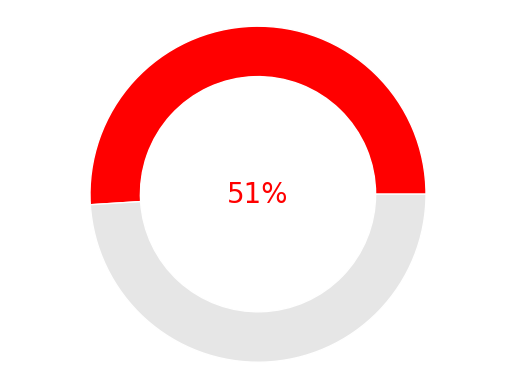

In [11]:
import matplotlib.pyplot as plt
probability = 0.51
fig, ax = plt.subplots()
size = 0.3

# Create data for the donut chart
values = [probability, 1 - probability]

color = 'red' if probability >0.5 else 'green'
colors = [color, '#e6e6e6']

ax.pie(values, colors=colors, radius=1, wedgeprops=dict(width=size, edgecolor='w'))

# Add a circle in the center to create the donut shape
centre_circle = plt.Circle((0,0), 1-size, color='white', fc='white', linewidth=0)
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')

# Add the percentage text in the center of the donut chart
plt.text(0, 0, f'{probability * 100:.0f}%', ha='center', va='center', fontsize=20, color=color)